In [1]:
print("MNIST Model Training")

MNIST Model Training


In [2]:
#Libraries
!pip install torchsummary
from tqdm import tqdm
from torchsummary import summary
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
SEED = 10
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
device = torch.device("cuda" if cuda else "cpu")
print(device)


CUDA Available? True
cuda


Modularizing Code for Model Steps

In [77]:
class FitEvaluate:
  def __init__(self,model,device, train_loader,test_loader):
    self.model, self.device, self.train_loader, self.test_loader = model, device, train_loader,test_loader
    self.train_losses,self.test_losses, self.train_acc, self.test_acc= [], [], [], []
    pass

  def train(self, optimizer, epoch):
    try:
      self.model.train()
      pbar = tqdm(self.train_loader)
      correct = 0
      processed = 0
      for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = self.model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        self.train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        self.train_acc.append(100*correct/processed)

    except Exception as ex:
      print(f"Exception in train function: {ex}")

  def test(self):
    try:
      self.model.eval()
      test_loss = 0
      correct = 0
      with torch.no_grad():
          for data, target in self.test_loader:
              data, target = data.to(device), target.to(device)
              output = model(data)
              test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
              pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
              correct += pred.eq(target.view_as(pred)).sum().item()

      test_loss /= len(self.test_loader.dataset)
      self.test_losses.append(test_loss)

      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(self.test_loader.dataset),
          100. * correct / len(self.test_loader.dataset)))

      self.test_acc.append(100. * correct / len(self.test_loader.dataset))

    except Exception as ex:
        print(f"Exception in test function: {ex}")

  def plot_accuracy_loss(self):
    t = [t_items.item() for t_items in self.train_losses]
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(t)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(self.train_acc[4000:])
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(self.test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(self.test_acc)
    axs[1, 1].set_title("Test Accuracy")

  def epoch_training(self,optimizer,scheduler = '',EPOCHS=15):
    try:
      for epoch in range(EPOCHS):
          print("EPOCH:", epoch)
          self.train(optimizer, epoch)
          if scheduler:
            scheduler.step()
          self.test()
      self.plot_accuracy_loss()

    except Exception as ex:
      print(f"Exception in test function: {ex}")



In [5]:
class MNIST_DATA:
  def __init__(self, train_transforms,test_transforms):
    self.train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
    self.test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
    self.train_loader = torch.utils.data.DataLoader(self.train, **dataloader_args) # train dataloader
    self.test_loader = torch.utils.data.DataLoader(self.test, **dataloader_args) # test dataloader
    print("Loaded the MNIST data!!!")
    pass

  def stats(self):
    try:
      train_data = self.train.train_data
      train_data = self.train.transform(train_data.numpy())
      print("********* Train Data Stats *********")
      print(' - Numpy Shape:', self.train.train_data.cpu().numpy().shape)
      print(' - Tensor Shape:', self.train.train_data.size())
      print(' - min:', torch.min(train_data))
      print(' - max:', torch.max(train_data))
      print(' - mean:', torch.mean(train_data))
      print(' - std:', torch.std(train_data))
      print(' - var:', torch.var(train_data))

    except Exception as ex:
      print(f"Exception in stats function: {ex}")


  def showimages(self, num_of_images):
    try:
        train_loader = self.train_loader
        dataiter = iter(train_loader)
        images, labels = next(dataiter)  # Use `next(dataiter)` instead of `dataiter.next()`

        print(" Batch Shape: ", images.shape)
        print(" Labels of the images: ", labels.shape)
        print(" Images")
        figure = plt.figure()
        for index in range(1, num_of_images + 1):
            plt.subplot(6, 10, index)
            plt.axis('off')
            plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
        plt.show()  # Make sure to display the plot

    except Exception as ex:
        print(f"Exception in showimages function: {ex}")


Step: 1 Basic setup, Skeleton, Lighter model

Transformations on Data

In [6]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


Train & Test Data

In [7]:
mnist_data = MNIST_DATA(train_transforms,test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 10.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 347kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.79MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Loaded the MNIST data!!!



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


*Data Statistics*

In [8]:
mnist_data.stats()

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


********* Train Data Stats *********
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


Visualizing Sample Images from the MNIST Dataset

 Batch Shape:  torch.Size([128, 1, 28, 28])
 Labels of the images:  torch.Size([128])
 Images


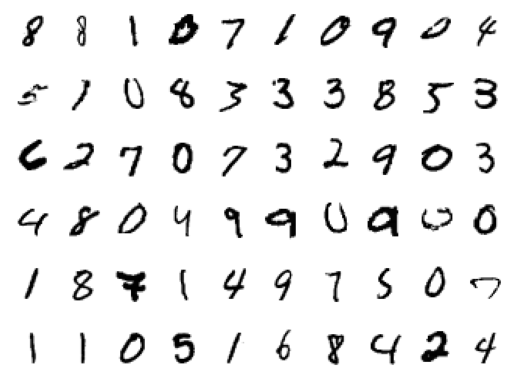

In [9]:
mnist_data.showimages(num_of_images=60)

Model Architecture

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) #output = 26*26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output = 24*24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output = 22*22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #output = 11*11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output = 11*11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) #output = 9*9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) #output = 7*7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output = 7*7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),

        ) # output = 1*1*10



    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

Model Summary

In [11]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3            [-1, 8, 24, 24]             576
              ReLU-4            [-1, 8, 24, 24]               0
            Conv2d-5           [-1, 16, 22, 22]           1,152
              ReLU-6           [-1, 16, 22, 22]               0
         MaxPool2d-7           [-1, 16, 11, 11]               0
            Conv2d-8            [-1, 8, 11, 11]             128
              ReLU-9            [-1, 8, 11, 11]               0
           Conv2d-10              [-1, 8, 9, 9]             576
             ReLU-11              [-1, 8, 9, 9]               0
           Conv2d-12             [-1, 16, 7, 7]           1,152
             ReLU-13             [-1, 16, 7, 7]               0
           Conv2d-14             [-1, 1

Training and testing the model

EPOCH: 0


Loss=0.47412967681884766 Batch_id=468 Accuracy=27.80: 100%|██████████| 469/469 [00:18<00:00, 25.50it/s]



Test set: Average loss: 0.4494, Accuracy: 8589/10000 (85.89%)

EPOCH: 1


Loss=0.11653430014848709 Batch_id=468 Accuracy=93.76: 100%|██████████| 469/469 [00:17<00:00, 27.47it/s]



Test set: Average loss: 0.0935, Accuracy: 9686/10000 (96.86%)

EPOCH: 2


Loss=0.12769411504268646 Batch_id=468 Accuracy=97.06: 100%|██████████| 469/469 [00:17<00:00, 27.25it/s]



Test set: Average loss: 0.0629, Accuracy: 9789/10000 (97.89%)

EPOCH: 3


Loss=0.02349969558417797 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:17<00:00, 26.09it/s]



Test set: Average loss: 0.0580, Accuracy: 9806/10000 (98.06%)

EPOCH: 4


Loss=0.05285802111029625 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:18<00:00, 25.15it/s]



Test set: Average loss: 0.0490, Accuracy: 9846/10000 (98.46%)

EPOCH: 5


Loss=0.0447750948369503 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:17<00:00, 27.02it/s]



Test set: Average loss: 0.0436, Accuracy: 9855/10000 (98.55%)

EPOCH: 6


Loss=0.03677144646644592 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:17<00:00, 27.04it/s]



Test set: Average loss: 0.0460, Accuracy: 9855/10000 (98.55%)

EPOCH: 7


Loss=0.014902535825967789 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:18<00:00, 25.66it/s]



Test set: Average loss: 0.0479, Accuracy: 9842/10000 (98.42%)

EPOCH: 8


Loss=0.010803557932376862 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:17<00:00, 27.01it/s]



Test set: Average loss: 0.0404, Accuracy: 9869/10000 (98.69%)

EPOCH: 9


Loss=0.03845849260687828 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:17<00:00, 26.98it/s]



Test set: Average loss: 0.0372, Accuracy: 9883/10000 (98.83%)

EPOCH: 10


Loss=0.0491597019135952 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:17<00:00, 27.09it/s]



Test set: Average loss: 0.0385, Accuracy: 9876/10000 (98.76%)

EPOCH: 11


Loss=0.015447375364601612 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s]



Test set: Average loss: 0.0415, Accuracy: 9864/10000 (98.64%)

EPOCH: 12


Loss=0.028080983087420464 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:18<00:00, 25.91it/s]



Test set: Average loss: 0.0362, Accuracy: 9887/10000 (98.87%)

EPOCH: 13


Loss=0.10403967648744583 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:17<00:00, 27.20it/s]



Test set: Average loss: 0.0406, Accuracy: 9873/10000 (98.73%)

EPOCH: 14


Loss=0.02143152616918087 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:18<00:00, 25.77it/s]



Test set: Average loss: 0.0364, Accuracy: 9886/10000 (98.86%)



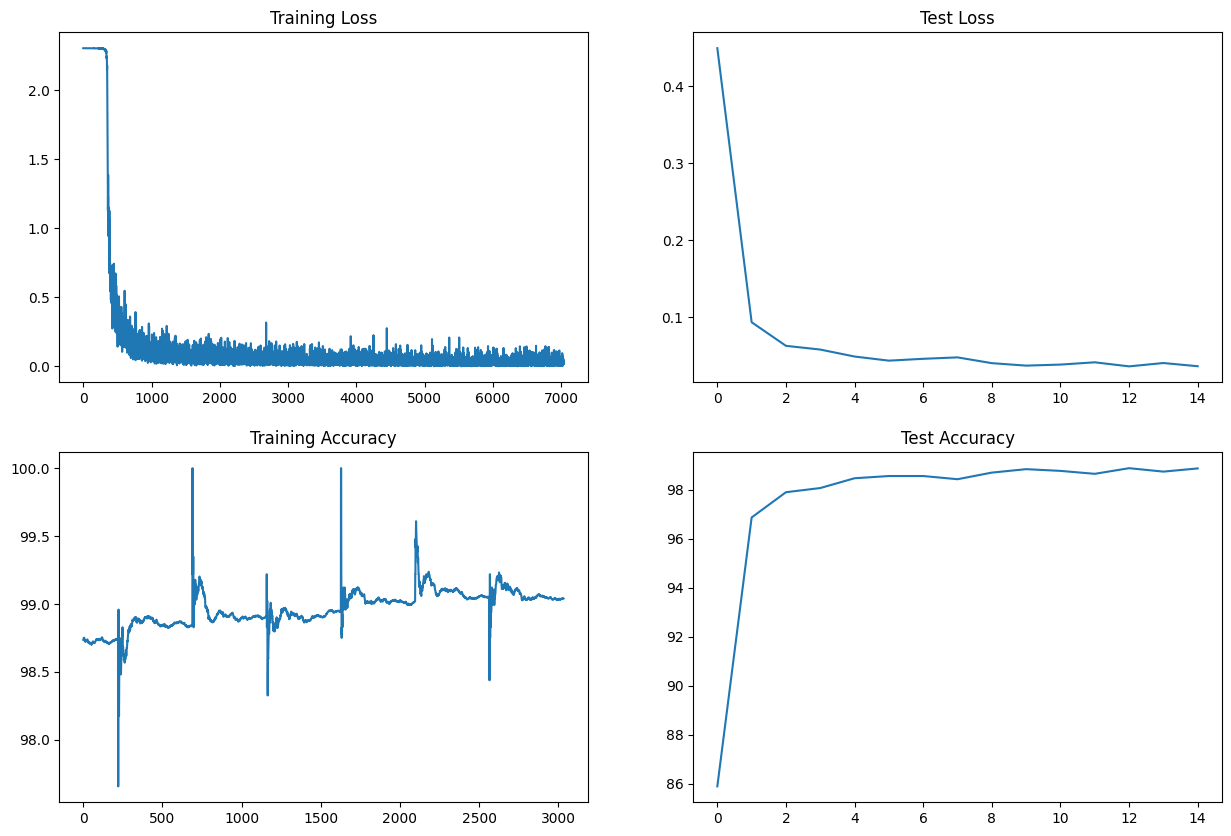

In [12]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

model_fiteval = FitEvaluate(model, device,mnist_data.train_loader,mnist_data.test_loader)
model_fiteval.epoch_training(optimizer)


**Target:**

  Basic setup, transformers, data loader, training & test loop, lighter model

**Result:**

  Parameters: 8,716

  Best Training Accuracy: 99.04 %

  Best Test Accuracy: 98.87%

**Analysis:** The model is light & no overfitting.

Step-2 Batch Normalization, Regularization, Gap

Transformations on Data

In [13]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


Train & Test Data

In [14]:
mnist_data = MNIST_DATA(train_transforms,test_transforms)

Loaded the MNIST data!!!


Data Statistics

In [15]:
mnist_data.stats()

********* Train Data Stats *********
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


Visualizing Sample Images from the MNIST Dataset



 Batch Shape:  torch.Size([128, 1, 28, 28])
 Labels of the images:  torch.Size([128])
 Images


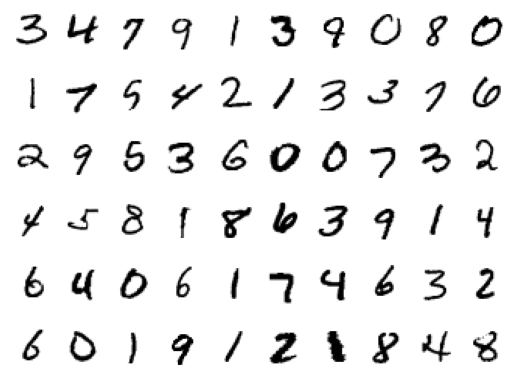

In [16]:
mnist_data.showimages(num_of_images=60)

Model Architecture

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) #output = 26*26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) # output = 24*24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output = 22*22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #output = 11*11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) # output = 11*11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) #output = 9*9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) #output = 7*7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output = 7*7

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1

        self.dropout = nn.Dropout(0.01)


    def forward(self, x):
        x = self.convblock1(x)
        x = self.dropout(x)
        x = self.convblock2(x)
        x = self.dropout(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.dropout(x)
        x = self.convblock4(x)
        x = self.dropout(x)
        x = self.convblock5(x)
        x = self.dropout(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

Model Summary

In [18]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
              ReLU-7            [-1, 8, 24, 24]               0
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,152
      BatchNorm2d-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
        MaxPool2d-12           [-1, 16, 11, 11]               0
          Dropout-13           [-1, 16, 11, 11]               0
           Conv2d-14            [-1, 8,

Training and testing our model

EPOCH: 0


Loss=0.36866310238838196 Batch_id=468 Accuracy=82.51: 100%|██████████| 469/469 [00:20<00:00, 23.44it/s]



Test set: Average loss: 0.2803, Accuracy: 9501/10000 (95.01%)

EPOCH: 1


Loss=0.20037102699279785 Batch_id=468 Accuracy=95.60: 100%|██████████| 469/469 [00:20<00:00, 22.95it/s]



Test set: Average loss: 0.1841, Accuracy: 9628/10000 (96.28%)

EPOCH: 2


Loss=0.11024260520935059 Batch_id=468 Accuracy=96.74: 100%|██████████| 469/469 [00:22<00:00, 20.92it/s]



Test set: Average loss: 0.1841, Accuracy: 9586/10000 (95.86%)

EPOCH: 3


Loss=0.22719921171665192 Batch_id=468 Accuracy=97.12: 100%|██████████| 469/469 [00:19<00:00, 23.74it/s]



Test set: Average loss: 0.1139, Accuracy: 9730/10000 (97.30%)

EPOCH: 4


Loss=0.1531744748353958 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:18<00:00, 24.95it/s]



Test set: Average loss: 0.1088, Accuracy: 9730/10000 (97.30%)

EPOCH: 5


Loss=0.1408979743719101 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:21<00:00, 21.85it/s]



Test set: Average loss: 0.0854, Accuracy: 9804/10000 (98.04%)

EPOCH: 6


Loss=0.10116346925497055 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:19<00:00, 23.70it/s]



Test set: Average loss: 0.0759, Accuracy: 9831/10000 (98.31%)

EPOCH: 7


Loss=0.05310705676674843 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:21<00:00, 21.42it/s]



Test set: Average loss: 0.0648, Accuracy: 9838/10000 (98.38%)

EPOCH: 8


Loss=0.06893087178468704 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:20<00:00, 23.00it/s]



Test set: Average loss: 0.0719, Accuracy: 9823/10000 (98.23%)

EPOCH: 9


Loss=0.042350441217422485 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:18<00:00, 25.40it/s]



Test set: Average loss: 0.0625, Accuracy: 9849/10000 (98.49%)

EPOCH: 10


Loss=0.11251624673604965 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:18<00:00, 25.42it/s]



Test set: Average loss: 0.0591, Accuracy: 9827/10000 (98.27%)

EPOCH: 11


Loss=0.11759167909622192 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:20<00:00, 23.11it/s]



Test set: Average loss: 0.0529, Accuracy: 9861/10000 (98.61%)

EPOCH: 12


Loss=0.15939024090766907 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:23<00:00, 20.02it/s]



Test set: Average loss: 0.0602, Accuracy: 9834/10000 (98.34%)

EPOCH: 13


Loss=0.10057675838470459 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:20<00:00, 23.44it/s]



Test set: Average loss: 0.0491, Accuracy: 9867/10000 (98.67%)

EPOCH: 14


Loss=0.05901745334267616 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:19<00:00, 24.44it/s]



Test set: Average loss: 0.0520, Accuracy: 9855/10000 (98.55%)



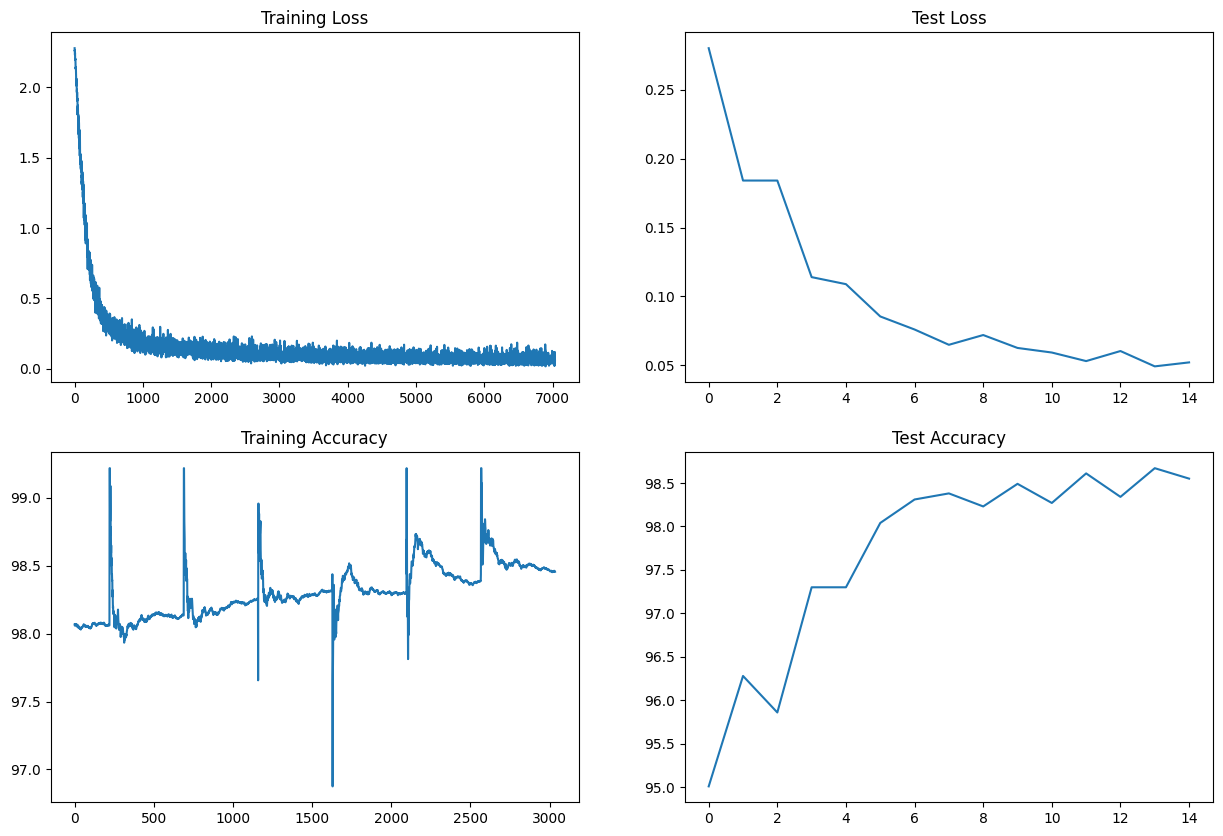

In [19]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

model_fiteval = FitEvaluate(model, device,mnist_data.train_loader,mnist_data.test_loader)
model_fiteval.epoch_training(optimizer)


**Target:**

  Added batch normalization, regularization (dropout) and Gap(global average pooling) also removed the last big kernel

**Result:**

  Parameters: 3,964

  Best Training Accuracy: 98.45 %

  Best Test Accuracy: 98.67%

**Analysis:** The model is more lighter but the accuracies have reduced. This is sort of predicted given that the comparision is between a 8716 parameter model to 3964 parameter model.

Step -3 Increase capacity, Correct max pool and Image augumentation

Transformations on Data

In [20]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

Train & Test Data

In [21]:
mnist_data = MNIST_DATA(train_transforms,test_transforms)

Loaded the MNIST data!!!


Data Statistics

In [22]:
mnist_data.stats()

Exception in stats function: Unexpected type <class 'numpy.ndarray'>


Visualizing Sample Images from the MNIST Dataset



 Batch Shape:  torch.Size([128, 1, 28, 28])
 Labels of the images:  torch.Size([128])
 Images


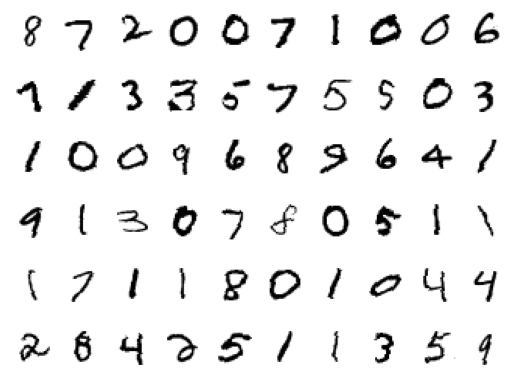

In [23]:
mnist_data.showimages(num_of_images=60)

Model Architecture

In [79]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(0.05)
        ) #output = 26*26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(0.05)
        ) # output = 24*24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output = 22*22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #output = 11*11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(0.05)
        ) # output = 11*11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(0.05)
        ) #output = 9*9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.05)
        ) #output = 7*7



        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output = 5*5

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        # OUTPUT BLOCK
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


Model Summary


In [80]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
              ReLU-7            [-1, 8, 24, 24]               0
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,152
      BatchNorm2d-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
        MaxPool2d-12           [-1, 16, 11, 11]               0
           Conv2d-13            [-1, 8, 11, 11]             128
      BatchNorm2d-14            [-1, 8,

Training and testing our model

EPOCH: 0


Loss=0.0035676322877407074 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:25<00:00, 18.23it/s]



Test set: Average loss: 0.0171, Accuracy: 9945/10000 (99.45%)

EPOCH: 1


Loss=0.002731218235567212 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:26<00:00, 17.55it/s]



Test set: Average loss: 0.0189, Accuracy: 9934/10000 (99.34%)

EPOCH: 2


Loss=0.01516597718000412 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:27<00:00, 17.26it/s]



Test set: Average loss: 0.0164, Accuracy: 9938/10000 (99.38%)

EPOCH: 3


Loss=0.01953345723450184 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:28<00:00, 16.50it/s]



Test set: Average loss: 0.0179, Accuracy: 9947/10000 (99.47%)

EPOCH: 4


Loss=0.0037464734632521868 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:26<00:00, 17.54it/s]



Test set: Average loss: 0.0182, Accuracy: 9938/10000 (99.38%)

EPOCH: 5


Loss=0.025417670607566833 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:26<00:00, 17.39it/s]



Test set: Average loss: 0.0184, Accuracy: 9944/10000 (99.44%)

EPOCH: 6


Loss=0.044548362493515015 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:26<00:00, 17.44it/s]



Test set: Average loss: 0.0178, Accuracy: 9938/10000 (99.38%)

EPOCH: 7


Loss=0.00782707054167986 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:27<00:00, 16.95it/s]



Test set: Average loss: 0.0187, Accuracy: 9942/10000 (99.42%)

EPOCH: 8


Loss=0.01141995657235384 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:27<00:00, 17.08it/s]



Test set: Average loss: 0.0182, Accuracy: 9937/10000 (99.37%)

EPOCH: 9


Loss=0.0127341253682971 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:26<00:00, 17.41it/s]



Test set: Average loss: 0.0181, Accuracy: 9939/10000 (99.39%)

EPOCH: 10


Loss=0.0056745391339063644 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:25<00:00, 18.50it/s]



Test set: Average loss: 0.0194, Accuracy: 9936/10000 (99.36%)

EPOCH: 11


Loss=0.02007751166820526 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:24<00:00, 18.91it/s]



Test set: Average loss: 0.0183, Accuracy: 9937/10000 (99.37%)

EPOCH: 12


Loss=0.0114647401496768 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:26<00:00, 17.49it/s]



Test set: Average loss: 0.0175, Accuracy: 9944/10000 (99.44%)

EPOCH: 13


Loss=0.0009390091872774065 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:24<00:00, 19.02it/s]



Test set: Average loss: 0.0183, Accuracy: 9945/10000 (99.45%)

EPOCH: 14


Loss=0.031011343002319336 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:25<00:00, 18.61it/s]



Test set: Average loss: 0.0189, Accuracy: 9942/10000 (99.42%)



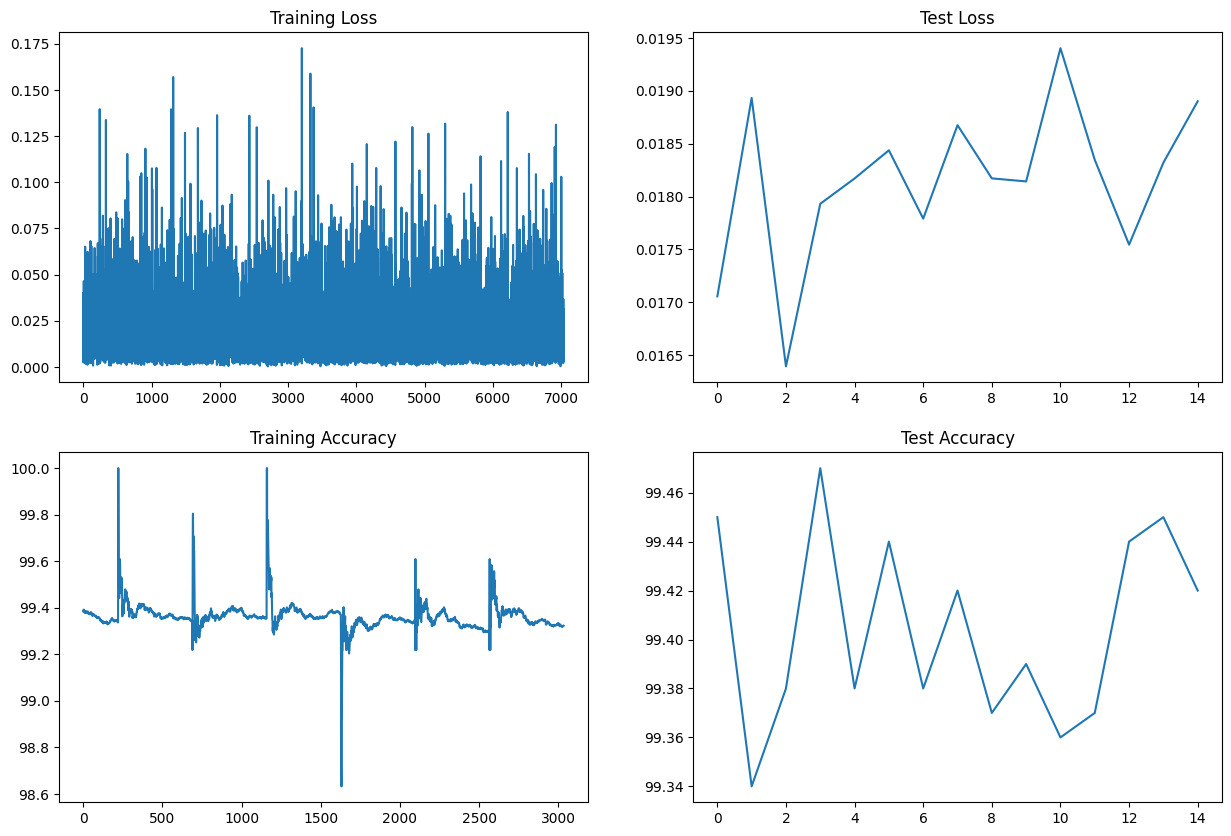

In [91]:
from torch.optim.lr_scheduler import StepLR
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=22, gamma=0.17)

model_fiteval = FitEvaluate(model, device,mnist_data.train_loader,mnist_data.test_loader)
model_fiteval.epoch_training(optimizer, scheduler = scheduler)


**Target:**

Applied a random rotation of 7 degrees on training sample, added one more layer after GAP and set up a learning rate scheduler.

**Result:**

  Parameters: 6,280

  Best Training Accuracy: 99.38 %

  Best Test Accuracy: 99.47%

**Analysis:** The model is slightly heavier as compared to model 2.The CNN model was successfully trained to predict digits from the MNIST dataset with fewer than 8k parameters, achieving a consistent accuracy of at least 99.4% in under 15 epochs, while minimizing the gap between training and test accuracy.